In [1]:
import requests
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow import keras
import os

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Nov 27 12:39:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

set up tpu

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

KeyError: ignored

# Load data

In [ ]:
url = "https://min-api.cryptocompare.com/data/histohour?fsym=BTC&tsym=USD&limit=2000"

In [ ]:
f = requests.get(url)
ipdata = f.json()


In [ ]:
btc = pd.read_csv('000001.SS.csv')
btc['Date'] = pd.to_datetime(btc['Date'])
btc.set_index('Date', inplace=True)

In [ ]:
btc.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-25,3417.514893,3423.485107,3362.326904,3362.326904,3362.326904,322100.0
2020-11-26,3360.061035,3371.454102,3344.281982,3369.732910,3369.732910,255900.0


Text(0, 0.5, 'Price (US$')

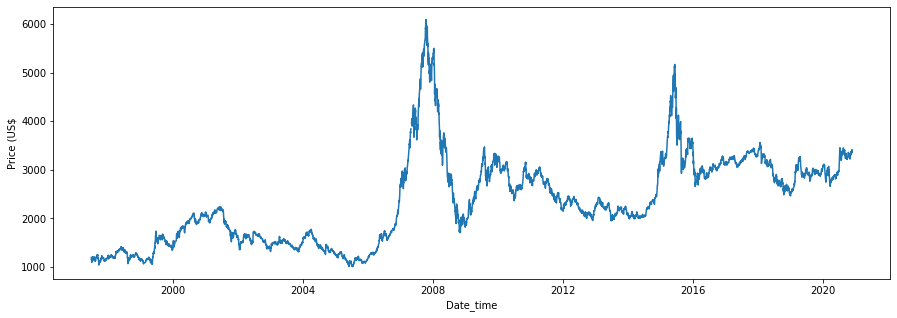

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(btc.Close)
plt.xlabel ('Date_time')
plt.ylabel ('Price (US$')

## Preprocess data

In [ ]:
scaler = MinMaxScaler()
# min-max normalization and scale the features in the 0-1 range.
close_price = btc['Close'].values.reshape(-1, 1) 
# The scaler expects the data to be shaped as (x, y)
scaled_close = scaler.fit_transform(close_price)
# removing NaNs (if any)
scaled_close = scaled_close[~np.isnan(scaled_close)] 
# reshaping data after removing NaNs
scaled_close = scaled_close.reshape(-1, 1) 


print(scaled_close.shape)

(5838, 1)


In [ ]:
SEQ_LEN = 150 
# creating a sequence of 100 hours at position 0.
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
       d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
"""Walk forward validation: 
Initial SEQ_LEN is defined above, so, walk forward will be shifting one position to the right and create another sequence.
The process is repeated until all possible positions are used."""
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95) 
"""Our model will use 1805 sequences representing 99 hours of Bitcoin price changes each for training. We shall be predicting the price for 96 hours in the future"""
print(X_train.shape, X_test.shape)


(5403, 149, 1) (285, 149, 1)


# Training

## Build model

In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Activation

In [ ]:
DROPOUT = 0.2 
# 20% Dropout is used to control over-fitting during training
WINDOW_SIZE = SEQ_LEN - 1
model = keras.Sequential()
# Input layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
"""Bidirectional RNNs allows to train on the sequence data in forward and backward direction."""
model.add(Dropout(rate=DROPOUT))
# 1st Hidden layer
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))
# 2nd Hidden layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
# output layer
model.add(Dense(units=1))
model.add(Activation('linear'))
"""Output layer has a single neuron (predicted Bitcoin price). We use Linear activation function which activation is proportional to the input."""
BATCH_SIZE = 64
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 149, 298)          179992    
_________________________________________________________________
dropout (Dropout)            (None, 149, 298)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 149, 596)          1423248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 596)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 298)               889232    
_________________________________________________________________
dense (Dense)                (None, 1)                 299       
_________________________________________________________________
activation (Activation)      (None, 1)                 0

## Train model

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1) 

Epoch 1/30
76/76 [==============================] - 8s 100ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 2/30
76/76 [==============================] - 6s 78ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 3/30
76/76 [==============================] - 6s 78ms/step - loss: 0.0058 - val_loss: 4.1895e-04
Epoch 4/30
76/76 [==============================] - 6s 78ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 5/30
76/76 [==============================] - 6s 78ms/step - loss: 0.0097 - val_loss: 3.5601e-04
Epoch 6/30
76/76 [==============================] - 6s 78ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 7/30
76/76 [==============================] - 6s 78ms/step - loss: 4.8942e-04 - val_loss: 9.7077e-05
Epoch 8/30
76/76 [==============================] - 6s 78ms/step - loss: 4.0978e-04 - val_loss: 8.7487e-05
Epoch 9/30
76/76 [==============================] - 6s 78ms/step - loss: 2.6390e-04 - val_loss: 1.6159e-04
Epoch 10/30
76/76 [==============================] - 6s 78ms/step - loss: 2.

# Testing

In [ ]:
# prediction on test data
y_pred = model.predict(X_test) 
# invert the test to original values
y_test_inverse = pd.DataFrame(scaler.inverse_transform(y_test)) 
# assigning datetime
y_test_inverse.index = btc.index[-len(y_test):] 
print('Test data:',)
print(y_test_inverse.tail(3)); print();
# invert the prediction to understandable values
y_pred_inverse = pd.DataFrame(scaler.inverse_transform(y_pred)) 
# assigning datetime
y_pred_inverse.index = y_test_inverse.index 
print('Prediction data:',)
print(y_pred_inverse.tail(3))

Test data:
                      0
Date                   
2020-11-24  3414.489990
2020-11-25  3402.822998
2020-11-26  3362.326904

Prediction data:
                      0
Date                   
2020-11-24  3691.941162
2020-11-25  3716.465576
2020-11-26  3723.725342


In [ ]:
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')

MAE 0.06316911917887182
MSE 0.0040649874216323045
RMSE 0.06375725387461653


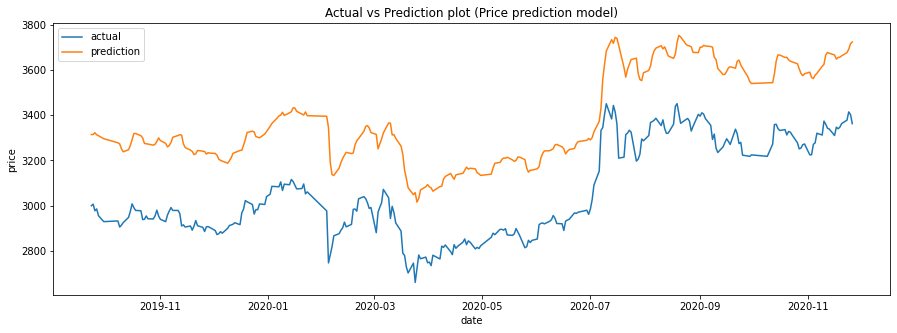

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(y_test_inverse)
plt.plot(y_pred_inverse)
plt.title('Actual vs Prediction plot (Price prediction model)')
plt.ylabel('price')
plt.xlabel('date')
plt.legend(['actual', 'prediction'], loc='upper left')
plt.show()

In [ ]:
last_ten_days_data = to_sequences(scaled_close[-(SEQ_LEN + 10):], SEQ_LEN)
y_pred = model.predict(last_ten_days_data) 
y_pred_inverse = pd.DataFrame(scaler.inverse_transform(y_pred)) 
print(y_pred_inverse)

             0
0  3429.276855
1  3485.554443
2  3485.470215
3  3465.985352
4  3463.942383
5  3429.496338
6  3464.851318
7  3456.538086
8  3464.531006
9  3479.261719
